In [135]:
import os
import os.path as osp

import numpy as np
import random

import open3d as o3d

import easydict
import matplotlib
import matplotlib.pyplot as plt

In [136]:
import sys
sys.path.append("..")
from utils import save_pcd, read_kitti_lidar_bin

In [137]:
sample_index = f"{random.randint(0, 7480 + 1):06d}"
print(sample_index)

007255


In [138]:
lidar_data = read_kitti_lidar_bin(f"../data/training/velodyne/{sample_index}.bin")
lidar_points = lidar_data[:, :3]
lidar_intensity = lidar_data[:, 3]
save_pcd(
    lidar_points,
    np.ones((len(lidar_points), 3)) * lidar_intensity.reshape((-1, 1)),
    0.05,
    "output/sample"
)

![snapshot](../doc/images/Snipaste_2024-11-28_20-27-59.png)
![snapshot](../doc/images/Snipaste_2024-11-29_10-28-22.png)


# label file field explanation

- `<object_type>:` The type of the annotated object. This can be one of the following: 'Car', 'Van', 'Truck', 'Pedestrian', - 'Person_sitting', 'Cyclist', 'Tram', 'Misc', or 'DontCare'. 'DontCare' is used for objects that are present but ignored for evaluation.
- `<truncation>`: The fraction of the object that is visible. It is a float value in the range [0.0, 1.0]. A value of 0.0 means the - object is fully visible, and 1.0 means the object is completely outside the image frame.
- `<occlusion>`: The level of occlusion of the object. It is an integer value indicating the degree of occlusion, where 0 means fully - visible, and higher values indicate increasing levels of occlusion.
- `<alpha>`: The observation angle of the object in radians, relative to the camera. It is the angle between the object's heading - direction and the positive x-axis of the camera.
- `<left>, <top>, <right>, <bottom>`: The 2D bounding box coordinates of the object in the image. They represent the pixel locations of - the top-left and bottom-right corners of the bounding box.
- `<height>, <width>, <length>`: The 3D dimensions of the object (height, width, and length) in meters.
- `<x>, <y>, <z>`: The 3D location of the object's centroid in the camera coordinate system (in meters).
- `<rotation_y>`: The rotation of the object around the y-axis in camera coordinates, in radians.

see also: https://medium.com/@abdulhaq.ah/explain-label-file-of-kitti-dataset-738528de36f4

In [139]:
# label the thing with colors
def is_float(item):
    try:
        item = float(item)
    except Exception as e:
        return False
    return True

label_field_name_list = [
    "object_type",
    "truncation",
    "occlusion",
    "alpha",
    "left", "top", "right", "bottom",
    "height", "width", "length",
    "x", "y", "z",
    "rotation_y"
]
label_list = []
with open(f"../data/training/label_2/{sample_index}.txt", 'r') as f:
    label_list = [tuple([float(item) if is_float(item) else item for item in line.strip().split()]) for line in f.readlines()]
# transform each label to dictionary item
label_list = [
    easydict.EasyDict({field:value for (field, value) in zip(label_field_name_list, item)}) for item in label_list
]

calib_field_name_list = [
    "P0", "P1", "P2", "P3",
    "R0_rect", "Tr_velo_to_cam", "Tr_imu_to_velo"
]
calib_info = []
with open(f"../data/training/calib/{sample_index}.txt", 'r') as f:
    calib_list = [line.strip().split() for line in f.readlines() if len(line.strip()) > 0]
calib_info = easydict.EasyDict(
    {seq[0][:-1]:[float(x) for x in seq[1:]] for seq in calib_list}
)

print(*label_list, sep='\n')
for key, val in calib_info.items():
    print(key, val)

{'object_type': 'Car', 'truncation': 0.0, 'occlusion': 2.0, 'alpha': 2.76, 'left': 803.79, 'top': 148.32, 'right': 885.64, 'bottom': 176.03, 'height': 1.52, 'width': 1.76, 'length': 4.1, 'x': 13.81, 'y': -0.28, 'z': 40.86, 'rotation_y': 3.09}
{'object_type': 'Car', 'truncation': 0.0, 'occlusion': 0.0, 'alpha': -1.52, 'left': 546.73, 'top': 164.24, 'right': 572.49, 'bottom': 184.47, 'height': 1.5, 'width': 1.78, 'length': 3.69, 'x': -3.48, 'y': 0.28, 'z': 55.04, 'rotation_y': -1.58}
{'object_type': 'Cyclist', 'truncation': 0.0, 'occlusion': 0.0, 'alpha': 0.01, 'left': 582.21, 'top': 164.95, 'right': 603.64, 'bottom': 185.75, 'height': 1.74, 'width': 0.6, 'length': 1.79, 'x': -1.0, 'y': 0.43, 'z': 60.22, 'rotation_y': -0.0}
{'object_type': 'Pedestrian', 'truncation': 0.0, 'occlusion': 1.0, 'alpha': 3.12, 'left': 611.27, 'top': 162.12, 'right': 617.77, 'bottom': 183.19, 'height': 1.8, 'width': 0.68, 'length': 1.44, 'x': 1.44, 'y': 0.22, 'z': 61.35, 'rotation_y': -3.14}
{'object_type': 'Pe

# add label colors

Note that `<x,y,z>` coordinates in the KITTI object detection dataset are placed under the camera coordinate, if it's to be used with lidar point cloud data, you should do the coordinate transformation first

![kitti_coor](../doc/images/kitti_coord.png)

In [140]:
from utils import R_mat, T_vec

points = np.copy(lidar_points)
colors = np.linalg.norm(points, axis=1) / np.linalg.norm(points.max(axis=0))
norm = matplotlib.colors.Normalize(vmin=colors.min(), vmax=colors.max()) 
# cmap = matplotlib.colormaps["pink"]
cmap = matplotlib.colormaps["rainbow"]
rgba = cmap(norm(colors))
colors = rgba[:, :3]
# colors = rgba[:, :3] * lidar_intensity.reshape((-1, 1))


anchor_points = []
anchor_colors = []
for label in label_list:
    if (label.object_type == "DontCare"):
        continue

    R_cam = R_mat(label.rotation_y, [0, 1, 0])
    T_cam = T_vec([label.x, label.y, label.z])
    
    # transform from camera coordinate to velodyn coordinate
    vly2cam = np.array(calib_info.Tr_velo_to_cam).reshape((3, 4))
    R_vly2cam = vly2cam[:3, :3]
    T_vly2cam = vly2cam[: ,  3].reshape((-1, 1))

    T_vly = R_vly2cam.T @ (T_cam - T_vly2cam)
    
    # visualize center point
    anchor_points.append(T_vly.T)
    anchor_colors.append([0.0, 1.0, 0.0])

    R_vly = R_vly2cam.T @ R_cam @ R_vly2cam

    bound_delta_ratio = 5e-2
    w, l, h, b = label.width/2 + label.width * bound_delta_ratio,\
              label.length/2 + label.length * bound_delta_ratio,\
              label.height + label.height * bound_delta_ratio,\
              1e-2
    # w = label.width / 2
    # l = label.length / 2
    # h = label.height
    lb_vly = np.array([-w, -l, +b]).reshape((-1, 1)) # left bottom
    rt_vly = np.array([+w, +l, +h]).reshape((-1, 1)) # right top
    
    lb_tgt = R_vly @ lb_vly + T_vly
    rt_tgt = R_vly @ rt_vly + T_vly
    
    anchor_points.append(lb_tgt.T)
    anchor_points.append(rt_tgt.T)
    anchor_colors.append([1.0, 0.0, 0.0])
    anchor_colors.append([1.0, 0.0, 0.0])

    points_msk = R_vly.T @ (points.T - T_vly)

    mask = np.all((points_msk.T >= lb_vly.T) & (points_msk.T <= rt_vly.T), axis=1)
    print(label.object_type, mask.astype(np.int32).sum() / len(points))

    # colors[mask] = np.random.rand(1, 3) * 0.5 + 0.3
    colors[mask] = np.array([1.0, 0.0, 1.0])

points = np.vstack([points, np.vstack(anchor_points)]) # add other points to main part
colors = np.vstack([colors, np.vstack(anchor_colors)]) # add other colors to main part
save_pcd(points, colors, 0.05, "doc/output/gdth")

Car 0.0
Car 0.00011231538159150896
Cyclist 0.00010429285433497261
Pedestrian 5.615769079575448e-05
Pedestrian 2.406758176960906e-05
[Open3D WARNING] Write PLY failed: unable to open file: doc/output/gdth.ply


RPly: Unable to create file


# bounding box segmentation result
![bbox_visualization](../doc/images/bbox_seg.png)

Green dots represent the center of the bottom of the bounding box, red dots represent left bottom and right top corners of the bounding box, orange dots represent the `object_type`

这里为了得到原标注文件的分割区域的可视化，花了不少功夫理解 KITTI 的相继坐标系之间的转换。原来旋转矩阵和坐标系变换矩阵并没有什么差别，是同一种仿射变换的不同称呼而一，毕竟旋转了之后的坐标其实就是用旋转后的坐标系（转换到的新坐标系）去表示原来的点而已。

# KITTI Lidar Remap

(370, 1224, 3)


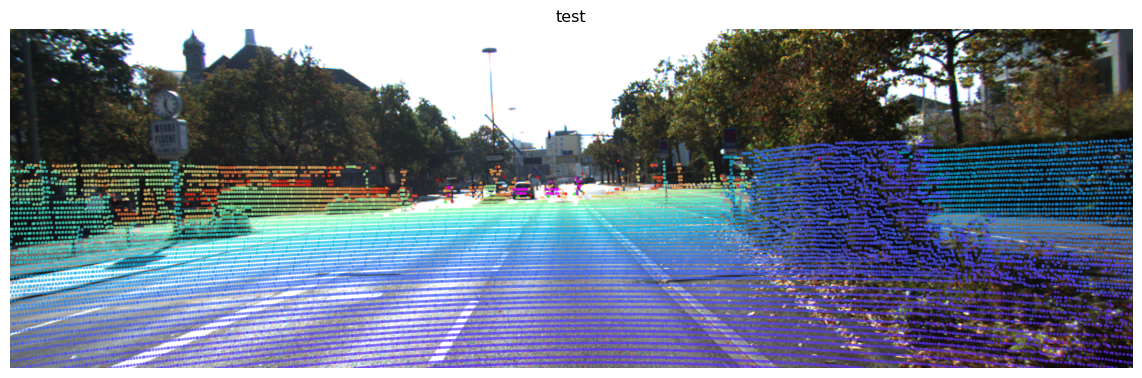

In [141]:
# https://github.com/azureology/kitti-velo2cam/blob/master/proj_velo2cam.py

import matplotlib.image


P2 = np.array(calib_info.P2).reshape((3, 4))
R0 = np.array(calib_info.R0_rect).reshape((3, 3))
TR = np.array(calib_info.Tr_velo_to_cam).reshape((3, 4))

# convert to homogeneous coordinates
R0 = np.pad(R0, ((0, 1), (0, 1)), mode="constant", constant_values=0)
R0[3][3] = 1
TR = np.pad(TR, ((0, 1), (0, 0)), mode="constant", constant_values=0)
TR[3][3] = 1

points_rmap = np.hstack([points, np.ones((points.shape[0], 1))]).T
colors_rmap = np.copy(colors)

rgb = colors_rmap

cam = (P2 @ R0 @ TR @ points_rmap)
cam[:2] /= cam[2, :]

del_mask1 = cam[2, :] < 0 # ?
# cam = np.delete(cam,np.where(cam[2,:]<0),axis=1)

png = matplotlib.image.imread(f"../data/training/image_2/{sample_index}.png")
IMG_H, IMG_W, _ = png.shape # row, column, _
print(png.shape)

plt.figure(figsize=(12,5),dpi=96,tight_layout=True)

# restrict canvas in range
plt.axis([0,IMG_W,IMG_H,0])
plt.imshow(png)

u, v, z = cam
u_out = np.logical_or(u < 0, u > IMG_W)
v_out = np.logical_or(v < 0, v > IMG_H)
# outlier = np.logical_or(u_out, v_out)
del_mask2 = np.logical_or(u_out, v_out)
# cam = np.delete(cam, np.where(outlier), axis=1)
mask = ~(del_mask1 | del_mask2)
cam_masked = cam[:, mask]
rgb_masked = rgb[mask]
plt.scatter(cam_masked[0], cam_masked[1], c=rgb_masked, alpha=0.5, s=2)
plt.axis("off")
plt.title("test")
plt.show()

# Spherical Projection

In [142]:
front_mask = points[:, 1] / np.linalg.norm(points[:, :2], axis=1)
# 前半球方向向量和正朝向向量夹角小于45度的点
front_mask = (points[:, 0] > 0) & (front_mask > np.sin(-np.pi / 4)) & (front_mask < np.sin(+np.pi / 4))
print(front_mask.astype(np.int32).sum() / len(points))
save_pcd(
    points[front_mask],
    colors[front_mask],
    out_name="output/front"
)

0.24842777385612527


0 511 0 62


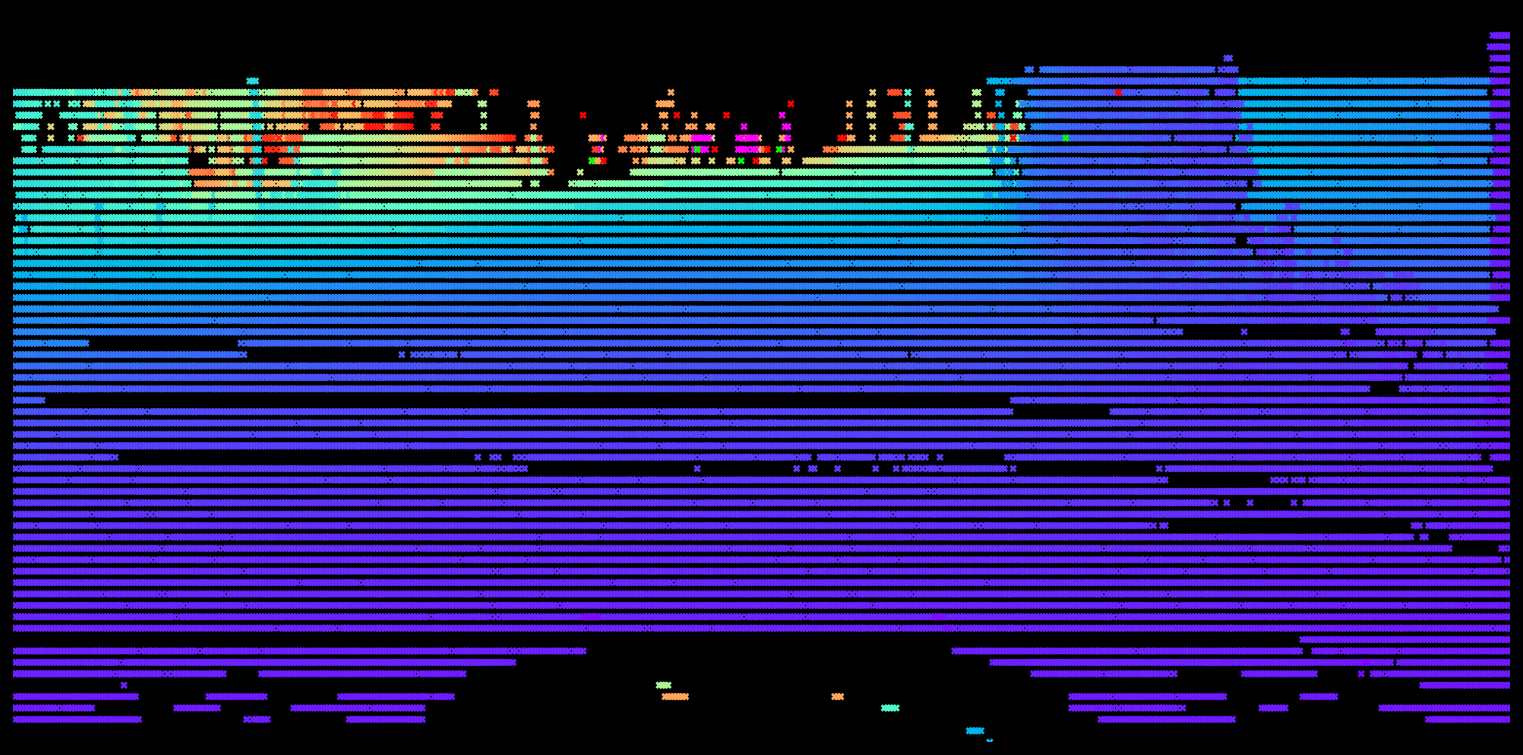

In [143]:
# compute sphere coordinate
front_points = points[front_mask]
front_colors = colors[front_mask]

x = np.arcsin(front_points[:, 1] / np.linalg.norm(front_points[:, :2], axis=1))
y = np.arcsin(front_points[:, 2] / np.linalg.norm(front_points, axis=1))

field_x_range, res_x = np.pi / 2, 512
filed_y_range, res_y = y.max() - y.min() + 1e-2, 64

delta_x = field_x_range / res_x
delta_y = filed_y_range / res_y

x = (x // delta_x).astype(np.int32)
y = (y // delta_y).astype(np.int32)

x = x - x.min()
y = y - y.min()

print(x.min(), x.max(), y.min(), y.max())


fig = plt.figure(figsize=(12,6), dpi=128, tight_layout=True)
fig.set_facecolor("black")
# restrict canvas in range
plt.axis([512, 0, 0, 64])
plt.axis("off")
plt.scatter(x, y, c=front_colors, s=10, marker='x')

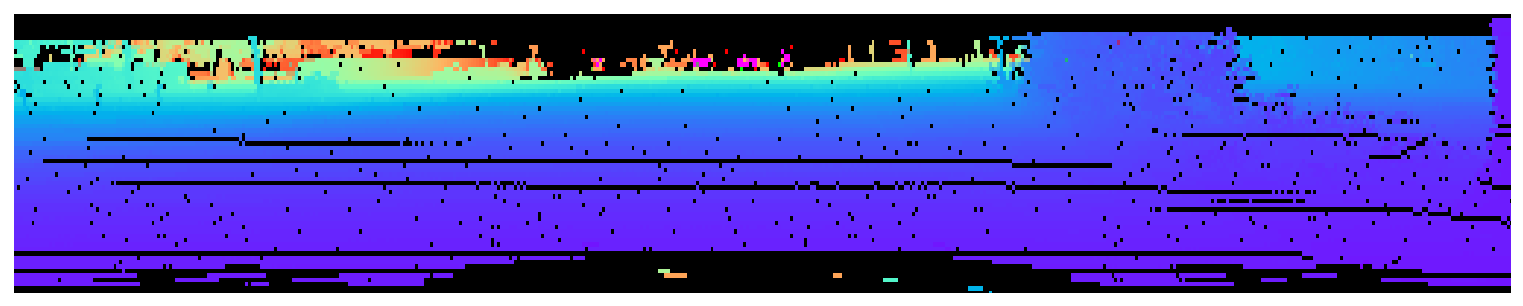

In [144]:
image = np.zeros((64, 512, 3))
count = np.ones((64, 512, 1)) * 1e-5
np.add.at(image, (y, x), front_colors)
np.add.at(count, (y, x), 1)
image = image / count
plt.figure(figsize=(12, 6), dpi=128, tight_layout=True)
plt.axis([512, 0, 0, 64])
plt.axis("off")
plt.imshow(image, aspect=1.5, interpolation='nearest')